In [ ]:
import pandas as pd
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import nltk
from gensim.models import Word2Vec
import pandas as pd
from glob import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB

from nltk import pos_tag, word_tokenize
from nltk import SnowballStemmer
from nltk import word_tokenize

In [ ]:
path = "../Sentences_50Agree.xlsx"
df = pd.read_excel(path)
df.columns = ['Sentence','Sentiment']
df

,Sentence,Sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative
2,With the new production plant the company woul...,positive
3,According to the company 's updated strategy f...,positive
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,positive
...,...,...
4840,LONDON MarketWatch -- Share prices ended lower...,negative
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral
4842,Operating profit fell to EUR 35.4 mn from EUR ...,negative
4843,Net sales of the Paper segment decreased to EU...,negative


In [ ]:
def conv(x):
  if x == 'negative' : 
    return(-1)
  if x == 'neutral':
    return(0)
  else : 
    return(1)

In [ ]:
df['Sentiment'] = df.apply(lambda r : conv(r['Sentiment']), axis=1)
df = df.drop_duplicates()
df

,Sentence,Sentiment
0,Technopolis plans to develop in stages an area...,0
1,The international electronic industry company ...,-1
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
...,...,...
4840,LONDON MarketWatch -- Share prices ended lower...,-1
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0
4842,Operating profit fell to EUR 35.4 mn from EUR ...,-1
4843,Net sales of the Paper segment decreased to EU...,-1


### Zipf's Law

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


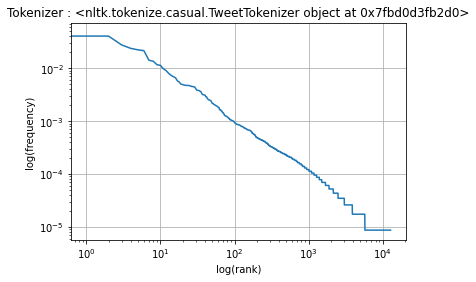

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import TweetTokenizer
import numpy as np
Sentences = [df['Sentence'].values[i] for i in range(len(df))]
tok = TweetTokenizer()
arr = np.array([tok.tokenize(x) for x in Sentences])
arr = [ x for X in arr for x in X]
c = Counter(arr)
d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']
  # Computing frequencies instead of occurences
nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)
  # Sorting by frequency, most frequent word at the top of the df
d = d.sort_values('freq', ascending=False)
plt.figure()
plt.grid()
plt.xscale('log')  # Using log scale
plt.yscale('log')  # Using log scale
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title("Tokenizer : {0}".format(tok))
x = list(range(d.shape[0]))
plt.plot(x, d.freq)
plt.show()

### Keeping only nouns and adjectives to plot occurences of words


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
d['type'] = nltk.pos_tag(list(d.word))
d['type'] = d.apply(lambda r : r['type'][1], axis=1)
d

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,word,occurences,freq,type
27,.,5508,0.047638,.
24,the,4708,0.040719,DT
23,",",4702,0.040667,","
8,of,3200,0.027676,IN
4,in,2749,0.023776,IN
...,...,...,...,...
6937,Communities,1,0.000009,NNPS
6936,Search,1,0.000009,NNP
6935,Location,1,0.000009,NNP
6934,Skanssi,1,0.000009,NNP


In [ ]:
d_clean = d[(d['type'].str[0].isin(['N', 'J'])) & (d['word'] != 's')]

### WordCloud representation of words occurences

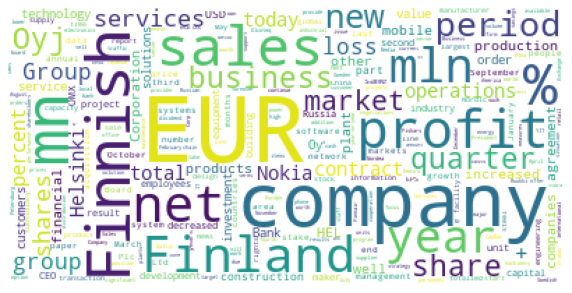

In [ ]:
from wordcloud import WordCloud
word_count_dict = d_clean.set_index('word')[['occurences']].to_dict()['occurences']
plt.figure(figsize=(10,10))
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_frequencies(word_count_dict)
plt.clf()
plt.imshow(wc)
plt.axis('off')
plt.show()

### Bar Plot of most frequent words

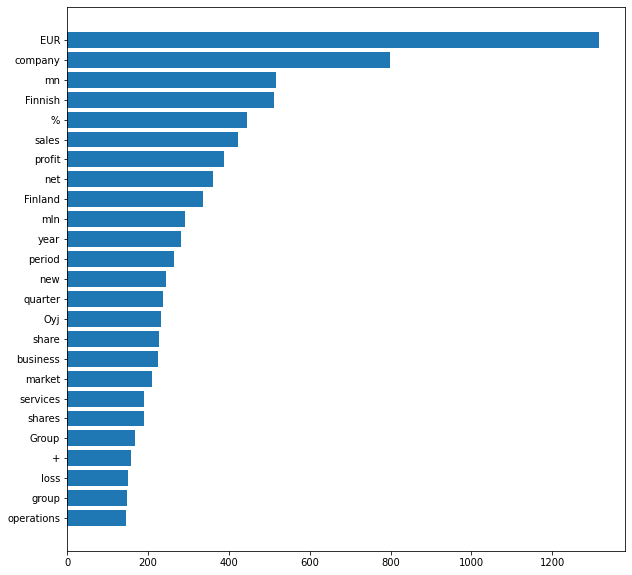

In [ ]:
plt.figure(figsize=(10,10))
top = 25
popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
#popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
plt.barh(range(top), [word_count_dict[w] for w in reversed(popular_words[0:top])])
plt.yticks([x for x in range(top)], reversed(popular_words[0:top]))
#plt.title(title)
plt.show()

### Inbalanced data : **604** negative, **2872** neutral and **1363** positive

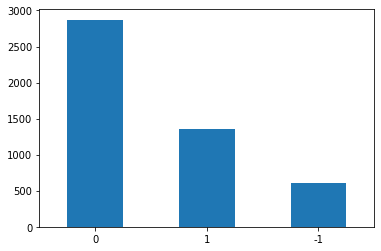

In [ ]:
df['Sentiment'].value_counts().plot.bar(rot=0)

### Checking if words are connoted 
*scale = (occurences in negative reviews + occurences in positive reviews)/(total of occurences)*

In [ ]:
test = df.copy()
test['Sentence'] = [tok.tokenize(x) for x in Sentences]
test_bis = test.apply(lambda x: pd.Series(x['Sentence']),axis=1).stack().reset_index(level=1, drop=True)
test_bis.name = 'Sentence'
test = test.drop('Sentence', axis=1).join(test_bis)
test['Notation'] = test['Sentiment']
count_df = test.groupby(['Sentence', 'Sentiment']).count().reset_index()
count_df['pond'] = count_df.apply(lambda x : x['Sentiment']*x['Notation'],axis=1)
count_df = count_df.groupby('Sentence').sum().drop(count_df.columns[1], axis=1)
count_df['scale'] = count_df.apply(lambda x : x['pond']/x['Notation'], axis=1)
count_df = count_df.drop(['pond'],axis=1).rename(columns={count_df.columns[0]:'Count'})
d['scale'] = list(count_df.loc[list(d.word)]['scale'])
d

,word,occurences,freq,type,scale
27,.,5508,0.047638,.,0.155229
24,the,4708,0.040719,DT,0.138700
23,",",4702,0.040667,",",0.161846
8,of,3200,0.027676,IN,0.127188
4,in,2749,0.023776,IN,0.173518
...,...,...,...,...,...
6937,Communities,1,0.000009,NNPS,1.000000
6936,Search,1,0.000009,NNP,1.000000
6935,Location,1,0.000009,NNP,1.000000
6934,Skanssi,1,0.000009,NNP,1.000000


In [ ]:
d_anal = d[d.occurences > 10]

In [ ]:
len(d_anal)

1276

Checking correlation between connotation of words and ranking in fequency. We could indeed assume that more a word occur, the more it is connoted as neutral. We see with the following figure that frequent word have are conoted positive or negative. We also see that on average words are conoted around 0.2. It could be explained by the unbalanced data

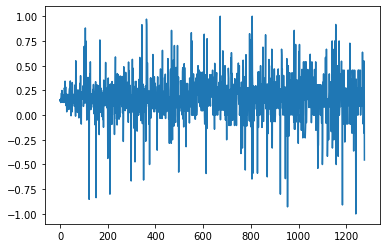

In [ ]:
x = np.linspace(0,len(d_anal),len(d_anal))
plt.plot(x,d_anal.scale)

In [ ]:
d_anal = d_anal.sort_values(by=['scale'],ascending='False')
d_anal

,word,occurences,freq,type,scale
11343,warning,11,0.000095,VBG,-1.000000
4690,temporarily,14,0.000121,RB,-0.928571
5133,lay,11,0.000095,VBD,-0.909091
617,down,95,0.000822,IN,-0.852632
535,decreased,79,0.000683,JJ,-0.835443
...,...,...,...,...,...
3084,awarded,35,0.000303,VBN,0.914286
3550,efficient,12,0.000104,JJ,0.916667
879,grew,34,0.000294,VBD,0.970588
3467,improved,21,0.000182,JJ,1.000000


In [ ]:
d_anal.head(20) #the most negatively conoted words

,word,occurences,freq,type,scale
11343,warning,11,0.000095,VBG,-1.000000
4690,temporarily,14,0.000121,RB,-0.928571
5133,lay,11,0.000095,VBD,-0.909091
617,down,95,0.000822,IN,-0.852632
535,decreased,79,0.000683,JJ,-0.835443
858,fell,55,0.000476,VBD,-0.800000
3581,dropped,15,0.000130,VBD,-0.800000
3346,lower,39,0.000337,JJR,-0.666667
36,off,35,0.000303,RP,-0.657143
8644,lay-offs,17,0.000147,JJ,-0.647059


In [ ]:
d_anal.tail(20) #the most positively connoted words

,word,occurences,freq,type,scale
944,Africa,12,0.000104,NNP,0.750000
59,increase,100,0.000865,VB,0.750000
545,partnership,12,0.000104,NN,0.750000
3007,good,24,0.000208,JJ,0.750000
203,signed,75,0.000649,VBD,0.760000
3026,able,17,0.000147,JJ,0.764706
64,improve,22,0.000190,VB,0.772727
164,strengthen,16,0.000138,NN,0.812500
1042,Both,22,0.000190,NNP,0.818182
424,rise,17,0.000147,NN,0.823529


Nous allons utiliser un vecteur de type "Bag-of-Words" (BoW), contenant les comptes de chaque mot (indépendamment de leur ordre d'occurrence) dans le document. 

Si nous considérons l'ensemble de tous les mots apparaissant dans nos $T$ documents d'apprentissage, que nous notons $V$ (Vocabulaire), nous pouvons créer **un index**, qui est une bijection associant à chaque $w$ mot un entier, qui sera sa position dans $V$. 

Ainsi, pour un document extrait d'un ensemble de documents contenant $|V|$ mots différents, une représentation BoW sera un vecteur de taille $|V|$, dont la valeur à l'index d'un mot $w$ sera son nombre d'occurrences dans le document. 

Nous pouvons utiliser la classe **CountVectorizer** de scikit-learn pour obtenir ces représentations :

In [ ]:
from sklearn.model_selection import train_test_split
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(df['Sentence'], df['Sentiment'], test_size=.2)

In [ ]:
# Create and fit the vectorizer to the training data
vectorizer = CountVectorizer()

train_bow = vectorizer.fit_transform(train_texts_splt)

print(vectorizer.get_feature_names())
train_bow.toarray()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00', '000', '000063', '002', '0025', '003', '007', '008', '01', '0101138', '012', '0187274', '019', '02', '023', '029', '03', '030', '031', '035', '04', '045', '046', '047', '0491', '05', '052', '06', '060', '063', '064', '067', '07', '070', '0711', '0762', '08', '084', '087', '089', '09', '094', '0941', '10', '100', '1000', '100mn', '101', '102', '1023', '103', '104', '105', '106', '107', '108', '109mn', '10mn', '10th', '11', '110', '111', '1112', '112', '113', '114', '115', '116', '117', '117mn', '118', '119', '11m', '12', '120', '1200', '121', '122', '124', '125', '127', '128', '129', '12mp', '12th', '13', '130', '131', '131000', '132', '133', '134', '135', '137', '139', '14', '140', '141', '1411', '142', '143', '145', '147', '149', '15', '150', '150mn', '151', '152', '154', '155', '156', '158', '159', '15mn', '15th', '15us', '16', '160', '161', '162', '163', '164', '1649', '165', '167', '168', '169', '16mn', '17', '170', '172', '173', '1744900', '175', '1750', '176', '177mn', '17

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
valid_bow = vectorizer.transform(val_texts)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_bow, train_labels_splt)
y_test_pred = clf.predict(valid_bow)

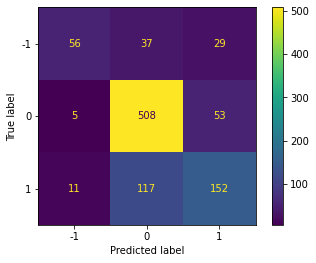

In [ ]:
cm = confusion_matrix(val_labels,y_test_pred, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
print(classification_report(val_labels,y_test_pred, labels = clf.classes_))

              precision    recall  f1-score   support

          -1       0.78      0.46      0.58       122
           0       0.77      0.90      0.83       566
           1       0.65      0.54      0.59       280

    accuracy                           0.74       968
   macro avg       0.73      0.63      0.67       968
weighted avg       0.73      0.74      0.73       968



### Amélioration des représentations

Principalement, les arguments de la classe vectorizer vont nous permettre de changer facilement la façon dont nos données textuelles sont représentées. On peut essayer de travailler sur les représentations *Bag-of-words* :
   
#### On évite de prendre en compte les mots trop fréquents :

On peut utiliser l'argument max_df=1.0 pour modifier la quantité de mots pris en compte. 

#### On peut essayer différentes granularités :

Plutôt que de compter uniquement les mots, nous pouvons compter des séquences de mots - limitées en taille, bien sûr. 
Nous appelons une séquence de $n$ mots un $n$-gramme : essayons d'utiliser des 2 et 3-grammes (bi- et trigrammes).
Nous pouvons également essayer d'utiliser des séquences de caractères au lieu de séquences de mots.

In [ ]:
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline
pipeline_base.fit(train_texts_splt,train_labels_splt)
y_test1_pred = pipeline_base.predict(val_texts)

In [ ]:
print(classification_report(val_labels,y_test1_pred))

              precision    recall  f1-score   support

          -1       0.78      0.46      0.58       122
           0       0.77      0.90      0.83       566
           1       0.65      0.54      0.59       280

    accuracy                           0.74       968
   macro avg       0.73      0.63      0.67       968
weighted avg       0.73      0.74      0.73       968



In [ ]:
# Bigrams
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word',ngram_range=(1, 2), stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt,train_labels_splt)
y_test1_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels,y_test1_pred))

              precision    recall  f1-score   support

          -1       0.84      0.42      0.56       122
           0       0.75      0.92      0.83       566
           1       0.68      0.53      0.60       280

    accuracy                           0.74       968
   macro avg       0.76      0.62      0.66       968
weighted avg       0.74      0.74      0.73       968



In [ ]:
# Trigrams
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word',ngram_range=(1, 3), stop_words=None)),
    ('clf', MultinomialNB()),
])
pipeline_base.fit(train_texts_splt,train_labels_splt)
y_test1_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels,y_test1_pred))

              precision    recall  f1-score   support

          -1       0.85      0.47      0.60       122
           0       0.75      0.93      0.83       566
           1       0.72      0.52      0.60       280

    accuracy                           0.75       968
   macro avg       0.77      0.64      0.68       968
weighted avg       0.75      0.75      0.73       968



In [ ]:
# Characters
pipeline_base = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='char', stop_words=None)),
    ('clf', MultinomialNB()),
])
# Fit and test the pipeline
pipeline_base.fit(train_texts_splt,train_labels_splt)
y_test1_pred = pipeline_base.predict(val_texts)
print(classification_report(val_labels,y_test1_pred))


              precision    recall  f1-score   support

          -1       0.27      0.48      0.34       122
           0       0.68      0.80      0.73       566
           1       0.43      0.12      0.19       280

    accuracy                           0.56       968
   macro avg       0.46      0.47      0.42       968
weighted avg       0.55      0.56      0.53       968



### Tf-idf

Il s'agit du produit de la fréquence du terme (TF) et de sa fréquence inverse dans les documents (IDF).
Cette méthode est généralement utilisée pour mesurer l'importance d'un terme $i$ dans un document $j$ par rapport au reste du corpus, à partir d'une matrice d'occurrences $ mots \times documents$. Ainsi, pour une matrice $\mathbf{T}$ de $|V|$ termes et $D$ documents :
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}}$$

$$\text{IDF}(T, w) = \log(\frac{D}{|d|})$$ avec : d tel que  $$T_{w,d} > 0$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

On peut l'adapter à notre cas en considérant que le contexte du deuxième mot est le document. Cependant, le TF-IDF est généralement mieux adapté aux matrices de faible densité, car il pénalisera les termes qui apparaissent dans une grande partie des documents. 

In [ ]:
# Fit and test a pipeline with tf-idf
pipeline_base_tf_idf = Pipeline([
    ('vect', CountVectorizer(max_features=30000, analyzer='word', stop_words=None)),
    ('tfid', TfidfTransformer()),
    ('clf', MultinomialNB()),  
])
pipeline_base_tf_idf.fit(train_texts_splt,train_labels_splt)
y_test1_pred = pipeline_base_tf_idf.predict(val_texts)
print(classification_report(val_labels,y_test1_pred))

              precision    recall  f1-score   support

          -1       1.00      0.02      0.05       122
           0       0.66      0.99      0.79       566
           1       0.66      0.29      0.40       280

    accuracy                           0.66       968
   macro avg       0.77      0.43      0.41       968
weighted avg       0.70      0.66      0.58       968



## Dense Representations 

## Embeddings de mots : Représentations distribuées via l'hypothèse distributionnelle 

**Objectif** : Nous allons essayer d'obtenir des Dense Representations  (en tant que vecteurs de nombres réels) de mots (et éventuellement de phrases).

Un mot peut être caractérisé par les mots qui l'accompagnent, via le comptage des cooccurrences. Deux mots ayant un sens similaire auront une distribution contextuelle similaire et sont donc plus susceptibles d'apparaître dans des contextes similaires. Cette hypothèse peut être utilisée pour justifier l'application des statistiques à la sémantique (extraction d'information, analyse sémantique). Elle permet également une certaine forme de généralisation : nous pouvons supposer que les informations dont nous disposons sur un mot seront généralisées aux mots ayant une distribution similaire. 

L'objectif est d'obtenir des représentations distribuées afin d'être en mesure de:
- Réaliser directement une analyse de surface sémantique.
- L'utiliser comme source d'information pour d'autres modèles et applications liés au langage, notamment pour l'analyse des sentiments. 


## Getting representations: counts of occurrences and co-occurrences

## Obtenir des représentations : comptages d'occurrences et de co-occurrences

Supposons que nous ayons un corpus contenant $T$ mots différents. Nous allons construire une matrice $\mathbf{M}$ de taille $T \times T$ qui contiendra le nombre de cooccurrences entre les mots.

Nous pouvons choisir d'utiliser différentes échelles : le document, la phrase, le groupe nominal, ou simplement une fenêtre de $k$ mots, selon l'information que nous voulons capturer.


- Comment quantifier l'importance des comptages ? 

Par exemple, on peut donner un poids décroissant à une cooccurrence en fonction de la distance entre les deux mots concernés ($\frac{1}{d+1}$ pour une séparation de $d$ mots).

Pour commencer, nous allons implémenter séparément une fonction renvoyant le vocabulaire. Il faudra ici pouvoir contrôler sa taille, soit en indiquant un nombre maximum de mots, soit un nombre minimum d'occurrences pour prendre en compte les mots. On ajoute, à la fin, un mot "inconnu" qui remplacera tous les mots qui ne figurent pas dans notre vocabulaire "limité". 

In [ ]:
def vocabulary(corpus, count_threshold=1, voc_threshold=0):
    # Count word in voc
    word_counts = {}
    for review in corpus:
        sent = word_tokenize(review)
        for word in sent:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1
    # We store the length of word_counts
    word_total_number = len(word_counts)
    
    filtered_word_counts = {} 
    filtered_word_counts["UNK"] = 0
    for key in word_counts:
        if len(filtered_word_counts) == voc_threshold:
            break
        else:
            if word_counts[key] >= count_threshold:
                filtered_word_counts[key] = word_counts[key]
            else:
                filtered_word_counts["UNK"] += word_counts[key]
    
    # Vocabulary_word_counts
    vocabulary_word_counts = {k: v for k, v in sorted(filtered_word_counts.items(), key=lambda item: -item[1])}
    a = vocabulary_word_counts['UNK']
    del vocabulary_word_counts['UNK']
    vocabulary = {list(vocabulary_word_counts.keys())[i]: i for i in range(len(vocabulary_word_counts))}
    vocabulary['UNK'] = len(vocabulary)
    vocabulary_word_counts['UNK'] = 0
    # Vocabulary   
    
    return vocabulary, vocabulary_word_counts

La fonction prend en entrée le corpus (une liste de chaînes de caractères, correspondant aux documents/sentences) et un vocabulaire, ainsi que la taille de la fenêtre de contexte.

In [ ]:
import nltk
nltk.download('punkt')
vocab_5k, word_counts_5k = vocabulary(df['Sentence'], 0, 3000)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Sentiment Analysis 
Nous allons maintenant utiliser ces représentations pour l'analyse des sentiments. 
Le modèle de base, comme précédemment, sera construit en deux étapes :
- Une fonction permettant d'obtenir des représentations vectorielles des critiques, à partir du texte, du vocabulaire, et des représentations vectorielles des mots. 
- Un classificateur prendra ces représentations en entrée et fera une prédiction. Pour cela, nous pouvons d'abord utiliser la régression logistique LogisticRegression de scikit-learn

In [ ]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.sum):
    representations = np.zeros( [len(texts), embeddings.shape[1]]) #Initialization
    emb_UNK = embeddings[vocabulary['UNK']] #We got here the UNK word
    for line, sent in enumerate(texts):
        sent = word_tokenize(sent) # list of the words of the sentence
        for word in sent:
            if word in vocabulary:
                representations[line] += embeddings[vocabulary[word]]                                
            else:
                representations[line] += emb_UNK
    return representations

In [ ]:
vocab_5k, word_counts_5k = vocabulary(train_texts_splt, 0, 5000)

## GloveEmbeddings

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/NLP/NLP

/content/drive/MyDrive/Colab Notebooks/NLP/NLP


In [ ]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors
path = "listeindex.xlsx"
index = pd.read_excel(path)


In [ ]:
liste_index = index[0]

In [ ]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(liste_index)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: liste_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

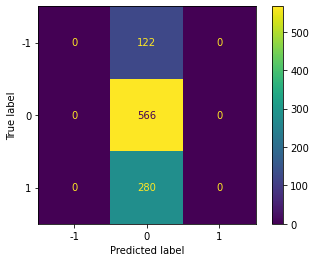

In [ ]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_5k)
train_rep = sentence_representations(train_texts_splt, vocab_5k, GloveEmbeddings)
val_rep = sentence_representations(val_texts, vocab_5k, GloveEmbeddings)
# Fit the classifier on the transformed training data and test it on the transformed validation data
log_reg = LogisticRegression(solver ='newton-cg')
log_reg.fit(train_rep,train_labels_splt)
predic_rep = log_reg.predict(val_rep)
#score_1 = log_reg.score(val_labels.T, predic_rep.T)
cm = confusion_matrix(val_labels,predic_rep, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=clf.classes_)
disp.plot()
disp1 = disp
plt.show()

In [ ]:
print(classification_report(val_labels,predic_rep))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       122
           0       0.58      1.00      0.74       566
           1       0.00      0.00      0.00       280

    accuracy                           0.58       968
   macro avg       0.19      0.33      0.25       968
weighted avg       0.34      0.58      0.43       968



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVDEmbeddings

In [ ]:
def co_occurence_matrix(corpus, vocabulary, window=0, distance_weighting=False):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
        distance_weighting (bool): indicates if we use a weight depending on the distance between words for co-oc counts
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for review in corpus:
        # Get the sentence
        sent = word_tokenize(review)
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [] 
        for word in sent:
            try:
                sent_idx.append(vocabulary[word])
            except KeyError:
                sent_idx.append(vocabulary['UNK'])
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx_i in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                if i-window<0:
                    pos_min = 0
                else :
                    pos_min = i-window
                l_ctx_idx = [sent_idx[j] for j in range(pos_min, i)]
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                if i ==0:
                    l_ctx_idx = []
                else:
                    l_ctx_idx = [sent_idx[ind] for ind in range(i)] 
            # Go through the list and update M[i,j]:    
            for j, idx_j in enumerate(l_ctx_idx):
                if distance_weighting:
                    weight = 1/(len(l_ctx_idx)-j)
                else:
                    weight = 1.0
                M[idx_i, idx_j] += weight
                M[idx_j, idx_i] += weight 
    return M

In [ ]:
M5dist = co_occurence_matrix(train_texts_splt, vocab_5k, window=5, distance_weighting=True)
#M20 = co_occurence_matrix(train_texts_splt, vocab_5k, window=20, distance_weighting=False)
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
SVDEmbeddings = svd.fit_transform(M5dist)
print(SVDEmbeddings.shape)
#SVDEmbeddings[vocab_5k['UNK']]

(5000, 300)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


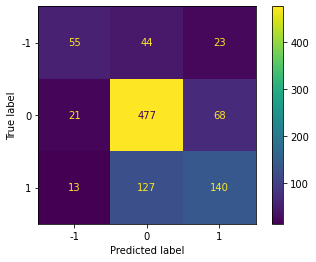

              precision    recall  f1-score   support

          -1       0.62      0.45      0.52       122
           0       0.74      0.84      0.79       566
           1       0.61      0.50      0.55       280

    accuracy                           0.69       968
   macro avg       0.65      0.60      0.62       968
weighted avg       0.68      0.69      0.68       968



In [ ]:
train_rep = sentence_representations(train_texts_splt, vocab_5k, SVDEmbeddings) #SVDEmbeddings 
val_rep = sentence_representations(val_texts, vocab_5k, SVDEmbeddings)
log_reg = LogisticRegression(solver ='newton-cg')
log_reg.fit(train_rep,train_labels_splt)
predic_rep = log_reg.predict(val_rep)
cm = confusion_matrix(val_labels,predic_rep, labels = clf.classes_)
b = cm
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=clf.classes_)
disp.plot()
disp2 = disp
plt.show()
print(classification_report(val_labels,predic_rep))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [ ]:
! pip install datasets
! pip install transformers
! pip install torchinfo

     |████████████████████████████████| 325 kB 13.8 MB/s 
     |████████████████████████████████| 77 kB 7.8 MB/s 
     |████████████████████████████████| 212 kB 88.8 MB/s 
     |████████████████████████████████| 1.1 MB 75.0 MB/s 
     |████████████████████████████████| 136 kB 78.2 MB/s 
     |████████████████████████████████| 127 kB 86.1 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 81.9 MB/s 
     |████████████████████████████████| 271 kB 71.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 4.0 MB 15.0 MB/s

In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

### Using FastText pre trained vectors 

In [ ]:
from torchtext.vocab import GloVe, vocab, FastText

pretrained_vectors = FastText(language='en')

In [ ]:
from torchtext.vocab import GloVe, FastText, vocab

pretrained_vocab = vocab(pretrained_vectors.stoi)
unk_token = "<unk>"
unk_index = 0
pad_token = '<pad>'
pad_index = 1
pretrained_vocab.insert_token("<unk>",unk_index)
pretrained_vocab.insert_token("<pad>", pad_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried 
pretrained_vocab.set_default_index(unk_index)
pretrained_embeddings = pretrained_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
pretrained_embeddings.size()

torch.Size([2519371, 300])

In [ ]:
df = df.drop(columns = df.columns[1])
df.columns = ['text','label']
df

,text,label
0,Technopolis plans to develop in stages an area...,0
1,The international electronic industry company ...,-1
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
...,...,...
4840,LONDON MarketWatch -- Share prices ended lower...,-1
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0
4842,Operating profit fell to EUR 35.4 mn from EUR ...,-1
4843,Net sales of the Paper segment decreased to EU...,-1


Splitting the data in train, test and evaluation datasets (80%, 10% and 10%)

In [ ]:
df_resampled = pd.concat([df[df.label !=0], df[df.label == 0].sample(n=1363)]).reset_index(drop=True)
df_resampled

,text,label
0,The international electronic industry company ...,-1
1,With the new production plant the company woul...,1
2,According to the company 's updated strategy f...,1
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
4,"For the last quarter of 2010 , Componenta 's n...",1
...,...,...
3325,"The contract includes design , construction , ...",0
3326,4 January 2011 - Finnish media company Alma Me...,0
3327,"May 29 , 2010 ( CompaniesandMarkets.com delive...",0
3328,The company 's objective is to offer the best ...,0


In [ ]:
df_binary = df[df.label != 0].reset_index(drop=True)
df_binary

,text,label
0,The international electronic industry company ...,-1
1,With the new production plant the company woul...,1
2,According to the company 's updated strategy f...,1
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
4,"For the last quarter of 2010 , Componenta 's n...",1
...,...,...
1962,HELSINKI Thomson Financial - Shares in Cargote...,-1
1963,LONDON MarketWatch -- Share prices ended lower...,-1
1964,Operating profit fell to EUR 35.4 mn from EUR ...,-1
1965,Net sales of the Paper segment decreased to EU...,-1


In [ ]:
def conv_2(x) : 
  if x ==-1 : 
    return(0)
  else : 
    return(x)
df_binary['label'] = df_binary.apply(lambda r : conv_2(r['label']), axis=1)
df_binary

,text,label
0,The international electronic industry company ...,0
1,With the new production plant the company woul...,1
2,According to the company 's updated strategy f...,1
3,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
4,"For the last quarter of 2010 , Componenta 's n...",1
...,...,...
1962,HELSINKI Thomson Financial - Shares in Cargote...,0
1963,LONDON MarketWatch -- Share prices ended lower...,0
1964,Operating profit fell to EUR 35.4 mn from EUR ...,0
1965,Net sales of the Paper segment decreased to EU...,0


In [ ]:
import random

mylist = [i for i in range(len(df))]
random.shuffle(mylist)
train_id = mylist[:int(0.8*len(df))]
eval_id = mylist[int(0.8*len(df)):int(0.9*len(df))]
test_id = mylist[int(0.9*len(df)):]

In [ ]:

train = df.iloc[train_id]
eval = df.iloc[eval_id]
test = df.iloc[test_id]

In [ ]:

mylist = [i for i in range(len(df_resampled))]
random.shuffle(mylist)
train_id = mylist[:int(0.8*len(df_resampled))]
eval_id = mylist[int(0.8*len(df_resampled)):int(0.9*len(df_resampled))]
test_id = mylist[int(0.9*len(df_resampled)):]

In [ ]:
train = df_resampled.iloc[train_id]
eval = df_resampled.iloc[eval_id]
test = df_resampled.iloc[test_id]

In [ ]:
mylist = [i for i in range(len(df_binary))]
random.shuffle(mylist)
train_id = mylist[:int(0.8*len(df_binary))]
eval_id = mylist[int(0.8*len(df_binary)):int(0.9*len(df_binary))]
test_id = mylist[int(0.9*len(df_binary)):]

In [ ]:
train = df_binary.iloc[train_id]
eval = df_binary.iloc[eval_id]
test = df_binary.iloc[test_id]

### Numerical Tokenisation of the datasets and creation of the dataset class and the dataloader for the training of the model

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset


### convert to Huggingface dataset
train = Dataset(pa.Table.from_pandas(train)).remove_columns('__index_level_0__')
eval = Dataset(pa.Table.from_pandas(eval)).remove_columns('__index_level_0__')
test = Dataset(pa.Table.from_pandas(test)).remove_columns('__index_level_0__')

In [ ]:

tok = TweetTokenizer()
def tokenize_pad_numericalize(entry, vocab_stoi, max_length=20):
  text = [ vocab_stoi[token] if token in vocab_stoi else vocab_stoi['<unk>'] for token in tok.tokenize(entry.lower())]
  padded_text = None
  if len(text) < max_length:   padded_text = text + [ vocab_stoi['<pad>'] for i in range(len(text), max_length) ] 
  elif len(text) > max_length: padded_text = text[:max_length]
  else:                        padded_text = text
  return padded_text

def tokenize_all(entries, vocab_stoi):
  res = {}
  res['text'] = [tokenize_pad_numericalize(entry, vocab_stoi, max_length=200) for entry in entries['text']]
  res['label'] = entries['label']
  return res

In [ ]:
train = train.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
eval = eval.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)
test = test.map(lambda e: tokenize_all(e, pretrained_vocab.get_stoi()), batched=True)


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from torch.utils.data import Dataset
import numpy as np

class ReviewDataset(Dataset):
    def __init__(self, data, args):
      # args is a dict, a nice way to share the global arguments (even accross multiple files)
      self.args = args
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "text": np.array(self.data[idx]['text']),
          "label": np.array(self.data[idx]['label'])
      }
      # warning: if you put   self.data['text'][idx]    it will take A LOT of time...
      ## The following code would take forever just to print next(iter(train_loader))['text'].shape
      # item = {
      #     "text": np.array(self.data['text'][idx]),
      #     "label": np.array(self.data['label'][idx])
      # }
      return item

In [ ]:
# Create DataLoader
from torch.utils.data import DataLoader
args = {'bsize': 64}
train_loader = DataLoader(ReviewDataset(train, args), batch_size=64, num_workers=2, shuffle=True, drop_last=True)
val_loader   = DataLoader(ReviewDataset(eval, args), batch_size=64, num_workers=2, shuffle=True, drop_last=True)
test_loader  = DataLoader(ReviewDataset(test, args), batch_size=64, num_workers=2, shuffle=True, drop_last=True)

### Definition of the model 

In [ ]:
class Classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, hidden_dim, num_layers, 
                 embedding_dim=300, dropout = 0.2, vec = pretrained_vectors.vectors):
        super().__init__()
        self.ebd = torch.nn.Embedding.from_pretrained(vec, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 3)
        self.dropout = nn.Dropout(0.2)        
        #activation function
        self.act = nn.Softmax()
        
    def forward(self, x):#, l):
        x = self.ebd(x)
        x = self.dropout(x)
        #x_pack = pack_padded_sequence(x, l, batch_first=True)

        lstm_out, (ht, ct) = self.lstm(x)#x_pack)
        dense_outputs=self.linear(ht[-1])
        #Final activation function
        outputs=self.act(dense_outputs)
        return outputs

In [ ]:
output_size = 3
hidden_dim = 256
num_layers = 2

net = Classifier(hidden_dim,num_layers)
print(net)

Classifier(
  (ebd): Embedding(2519370, 300)
  (lstm): LSTM(300, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softmax(dim=None)
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [ ]:
train_on_gpu=torch.cuda.is_available()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# training params

epochs = 10 

counter = 0
print_every = 100
clip=5 # gradient clipping
train_on_gpu = True
# move model to GPU, if available
net = net.to(device)
batch_size = 64
net.train()
# train for some number of epochs
for e in range(epochs):
    # batch loop
    for x in train_loader:
        counter += 1
        inputs = x['text'].to(device) 
        labels = x['label'].to(device)
        labels = labels + torch.ones(batch_size).to(device)
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output = net(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output, labels.to(int))
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_losses = []
            net.eval()
            for x in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history

                inputs = x['text'].to(device) 
                labels = x['label'].to(device)
                labels = labels + torch.ones(batch_size).to(device)
                output = net(inputs)
                val_loss = criterion(output, labels.to(int))

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 2/10... Step: 100... Loss: 0.926441... Val Loss: 0.946529
Epoch: 4/10... Step: 200... Loss: 0.895200... Val Loss: 0.962145
Epoch: 5/10... Step: 300... Loss: 0.863992... Val Loss: 0.957678
Epoch: 7/10... Step: 400... Loss: 0.973315... Val Loss: 0.964341
Epoch: 9/10... Step: 500... Loss: 1.003965... Val Loss: 0.955302
Epoch: 10/10... Step: 600... Loss: 0.983430... Val Loss: 0.952376


The loss is not satisfying 

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0
acc_it = []
pred = []
true = []

# init hidden state

net.eval()
# iterate over test data
for x in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history

    inputs = x['text'].to(device) 
    labels = x['label'].to(device) 
    labels = labels + torch.ones(batch_size).to(device)
    # get predicted outputs
    output = net(inputs)
    
    # calculate loss
    test_loss = criterion(output, labels.to(int))
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    #pred = torch.round(output.squeeze())  # rounds to the nearest integer
    _, tag_seq  = torch.max(output, 1)
    correct = (tag_seq.flatten() == labels.flatten()).float().sum()
    acc = correct / labels.flatten().size(0)
    acc_it.append(acc.item())
    pred.append(tag_seq)
    true.append(labels)
    
    
    # compare predictions to true label
    """
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    """


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
acc_it_avg = sum(acc_it)/len(acc_it)
print("Test accuracy: {:.3f}".format(acc_it_avg))

Test loss: 0.992
Test accuracy: 0.551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


On the test dataset, only one on two newspapers are accurately labelised. Actually the model only predicts neutral reviews

We train on a resampled dataset (df_resampled) so that we have as much neutral review as negative or positive. But we get the same result

In [ ]:
# training params

epochs = 50 

counter = 0
print_every = 100
clip=5 # gradient clipping
train_on_gpu = True
# move model to GPU, if available
net = net.to(device)
batch_size = 64
net.train()
# train for some number of epochs
for e in range(epochs):
    # batch loop
    for x in train_loader:
        counter += 1
        inputs = x['text'].to(device) 
        labels = x['label'].to(device)
        labels = labels + torch.ones(batch_size).to(device)
        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output = net(inputs)

        # calculate the loss and perform backprop
        loss = criterion(output, labels.to(int))
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_losses = []
            net.eval()
            for x in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history

                inputs = x['text'].to(device) 
                labels = x['label'].to(device)
                labels = labels + torch.ones(batch_size).to(device)
                output = net(inputs)
                val_loss = criterion(output, labels.to(int))

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 3/50... Step: 100... Loss: 1.083536... Val Loss: 1.070102
Epoch: 5/50... Step: 200... Loss: 1.036499... Val Loss: 1.066715
Epoch: 8/50... Step: 300... Loss: 1.038913... Val Loss: 1.062677
Epoch: 10/50... Step: 400... Loss: 1.058747... Val Loss: 1.068225
Epoch: 13/50... Step: 500... Loss: 1.071079... Val Loss: 1.066801
Epoch: 15/50... Step: 600... Loss: 1.026606... Val Loss: 1.066457
Epoch: 18/50... Step: 700... Loss: 1.083856... Val Loss: 1.064767
Epoch: 20/50... Step: 800... Loss: 1.030178... Val Loss: 1.067742
Epoch: 22/50... Step: 900... Loss: 0.997261... Val Loss: 1.067462
Epoch: 25/50... Step: 1000... Loss: 1.046435... Val Loss: 1.061598
Epoch: 27/50... Step: 1100... Loss: 1.058415... Val Loss: 1.066404
Epoch: 30/50... Step: 1200... Loss: 1.059492... Val Loss: 1.062730
Epoch: 32/50... Step: 1300... Loss: 1.045597... Val Loss: 1.065701
Epoch: 35/50... Step: 1400... Loss: 1.019871... Val Loss: 1.066632
Epoch: 37/50... Step: 1500... Loss: 1.047309... Val Loss: 1.065052
Epoch: 

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0
acc_it = []
pred = []
true = []

# init hidden state

net.eval()
# iterate over test data
for x in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history

    inputs = x['text'].to(device) 
    labels = x['label'].to(device) 
    labels = labels + torch.ones(batch_size).to(device)
    # get predicted outputs
    output = net(inputs)
    
    # calculate loss
    test_loss = criterion(output, labels.to(int))
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    #pred = torch.round(output.squeeze())  # rounds to the nearest integer
    _, tag_seq  = torch.max(output, 1)
    correct = (tag_seq.flatten() == labels.flatten()).float().sum()
    acc = correct / labels.flatten().size(0)
    acc_it.append(acc.item())
    pred.append(tag_seq)
    true.append(labels)
    
    
    # compare predictions to true label
    """
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    """


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
acc_it_avg = sum(acc_it)/len(acc_it)
print("Test accuracy: {:.3f}".format(acc_it_avg))

Test loss: 1.057
Test accuracy: 0.372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
tag_seq

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

We train on a data with only Negative and positive reviews (df_binary), we take a different model (SentimentRNN) and take a binary cross entropy. But we also get the same result

In [ ]:
import torch.nn as nn

class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, output_size, hidden_dim, n_layers, vec = pretrained_vectors.vectors, embedding_dim=300, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        #self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.ebd = torch.nn.Embedding.from_pretrained(vec, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Softmax(dim=1)

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)
        
        # embeddings and lstm_out
        embeds = self.ebd(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if(train_on_gpu):
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
          hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                   weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [ ]:
output_size = 2
hidden_dim = 256
num_layers = 2

net = SentimentRNN(hidden_dim,num_layers,output_size)
print(net)

SentimentRNN(
  (ebd): Embedding(2519370, 300)
  (lstm): LSTM(300, 2, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=2, out_features=256, bias=True)
  (sig): Softmax(dim=1)
)


In [ ]:
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [ ]:
# training params

epochs = 4 

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
net = net.to(device)

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for x in train_loader:

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history

        inputs = x['text'].to(device) 
        labels = x['label'].to(device) 
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for x in val_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history

                inputs = x['text'].to(device) 
                labels = x['label'].to(device)
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 0... Loss: 3.810270... Val Loss: 3.732221
Epoch: 1/4... Step: 0... Loss: 3.812211... Val Loss: 3.702864
Epoch: 1/4... Step: 0... Loss: 3.735205... Val Loss: 3.726366
Epoch: 1/4... Step: 0... Loss: 3.008893... Val Loss: 3.697213
Epoch: 1/4... Step: 0... Loss: 3.095537... Val Loss: 3.694512
Epoch: 1/4... Step: 0... Loss: 3.094783... Val Loss: 3.691863
Epoch: 1/4... Step: 0... Loss: 3.483807... Val Loss: 3.689252
Epoch: 1/4... Step: 0... Loss: 3.805353... Val Loss: 3.739238
Epoch: 1/4... Step: 0... Loss: 3.564126... Val Loss: 3.736647
Epoch: 1/4... Step: 0... Loss: 3.718052... Val Loss: 3.734080
Epoch: 1/4... Step: 0... Loss: 3.475417... Val Loss: 3.652851
Epoch: 1/4... Step: 0... Loss: 3.472919... Val Loss: 3.702828
Epoch: 1/4... Step: 0... Loss: 3.318883... Val Loss: 3.700366
Epoch: 1/4... Step: 0... Loss: 3.154859... Val Loss: 3.645583
Epoch: 1/4... Step: 0... Loss: 3.618850... Val Loss: 3.695532
Epoch: 1/4... Step: 0... Loss: 3.629460... Val Loss: 3.640843
Epoch: 1

In [ ]:
! pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 65.6 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 55.8 MB/s 
     |████████████████████████████████| 895 kB 50.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
! pip install tensorflow
!pip install tensorflow_hub
!pip install tensorflow_text

     |████████████████████████████████| 462 kB 5.1 MB/s 
     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
import tensorflow_text
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def build_classifier_model():
    
    text_input = tf.keras.layers.Input(
        shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [ ]:
tfhub_handle_encoder = \
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
classifier_model = build_classifier_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [ ]:
df

,Sentence,Sentiment
0,Technopolis plans to develop in stages an area...,0
1,The international electronic industry company ...,-1
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
...,...,...
4840,LONDON MarketWatch -- Share prices ended lower...,-1
4841,Rinkuskiai 's beer sales fell by 6.5 per cent ...,0
4842,Operating profit fell to EUR 35.4 mn from EUR ...,-1
4843,Net sales of the Paper segment decreased to EU...,-1


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(df['Sentence'] , df['Sentiment'], test_size=.2)
df_train, df_test = pd.DataFrame([]),pd.DataFrame([])
df_train['Sentence'], df_train['Sentiment'] = list(train_texts_splt), list(train_labels_splt)
df_test['Sentence'], df_test['Sentiment']  = list(val_texts), list(val_labels)

In [ ]:
train, valid = train_test_split(
    df_train,
    train_size=0.7,
    random_state=0,
    stratify=df_train['Sentiment'])
y_train, X_train = \
    train['Sentiment'], train.drop(['Sentiment'], axis=1)
y_valid, X_valid = \
    valid['Sentiment'], valid.drop(['Sentiment'], axis=1)
y_train_c = tf.keras.utils.to_categorical(
    y_train.astype('category').cat.codes.values, num_classes=3)
y_valid_c = tf.keras.utils.to_categorical(
    y_valid.astype('category').cat.codes.values, num_classes=3)

In [ ]:
history = classifier_model.fit(
    x=X_train['Sentence'].values,
    y=y_train_c,
    validation_data=(X_valid['Sentence'].values, y_valid_c),
    epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


85/85 [==============================] - 27s 207ms/step - loss: 0.7302 - accuracy: 0.6729 - val_loss: 0.5924 - val_accuracy: 0.7444
Epoch 2/5
85/85 [==============================] - 19s 222ms/step - loss: 0.4651 - accuracy: 0.8084 - val_loss: 0.4502 - val_accuracy: 0.8098
Epoch 3/5
85/85 [==============================] - 17s 202ms/step - loss: 0.3330 - accuracy: 0.8675 - val_loss: 0.4396 - val_accuracy: 0.8253
Epoch 4/5
85/85 [==============================] - 18s 209ms/step - loss: 0.2739 - accuracy: 0.8874 - val_loss: 0.4482 - val_accuracy: 0.8322
Epoch 5/5
85/85 [==============================] - 17s 201ms/step - loss: 0.2187 - accuracy: 0.9133 - val_loss: 0.4588 - val_accuracy: 0.8382


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

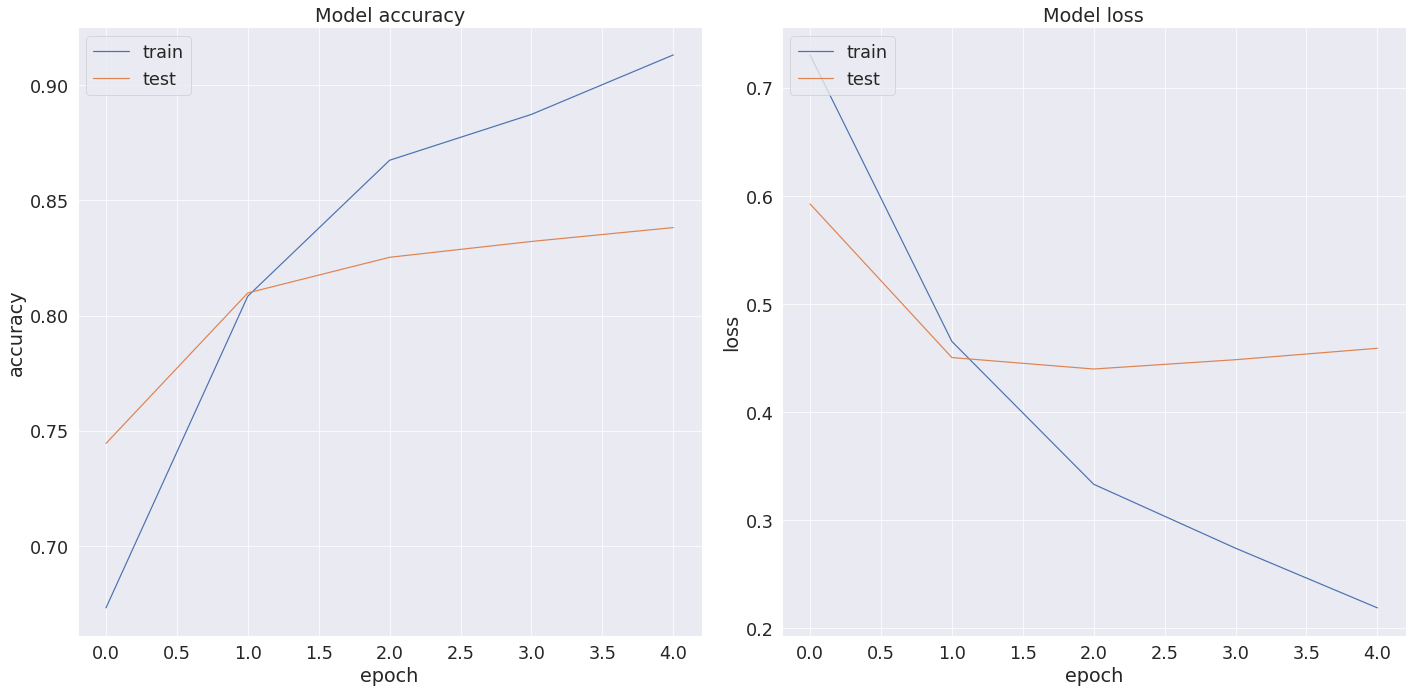

In [ ]:
sns.set()
sns.set_context("paper", font_scale=2) 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
sns.lineplot(ax=ax1, data=history.history['accuracy'])
sns.lineplot(ax=ax1, data=history.history['val_accuracy'])
ax1.set(
    title=f"Model accuracy",
    xlabel="epoch",
    ylabel="accuracy"
)
ax1.legend(['train', 'test'], loc='upper left')
ax2 = fig.add_subplot(122)
sns.lineplot(ax=ax2, data=history.history['loss'])
sns.lineplot(ax=ax2, data=history.history['val_loss'])
ax2.set(
    title=f"Model loss",
    xlabel="epoch",
    ylabel="loss"
)
ax2.legend(['train', 'test'], loc='upper left')

fig.tight_layout()
plt.show(fig) 

In [ ]:
y_proba_bert = classifier_model.predict(df_test['Sentence'].values)
y_pred_bert = np.argmax(y_proba_bert, axis=1)

In [ ]:
y_true = df_test['Sentiment'].astype('category').cat.codes.values
target_names = ['Negative', 'Neutral', 'Positive']

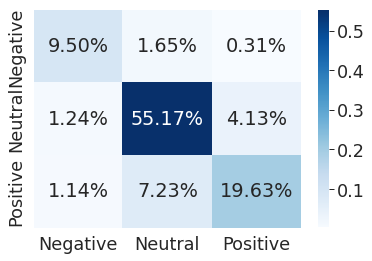

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred_bert)
sns.heatmap(
    cf_matrix/np.sum(cf_matrix),
    annot=True, fmt='.2%', cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names)